Plots of the experimental data.

Some notes:

As of May 18th, I fixed a couple of cells that had n/a and should be empty to be properly read.

As of August 4th, whenever TFA changes for a given pair, I'm preparing the code so that it takes the most common one as A. This has no effect, as the strongest TF is consistent for the WT data.

Notice that I am calculating synergy for each experiment, and then averaging over experiments.
So if for a given experiment there is not a measure for the combination at 1X1X and each individual TF at 2X then I cannot use that information.

Also, notice that in some excel sheets, HSF1m is called HSF1m1. Accounting for it here.

Outlier repeat measurements are removed based on the total measurements performed. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import itertools
import os
import glob
import matplotlib as mpl
from IPython.display import display
mpl.rcParams["font.size"]=12
import re

In [2]:
#Datasets generated by Minhee Park
f0='./data/RMCmod20190212transf_KC_minCMV full matrix_ALL.csv'#cMyc, BRD4, HSF1, HSF1m, SP1, empty

f7v1='./data/RMC_20181202_KC_M796(minCMV)_combo_tot 20ng_ALL_IRFPnorm.csv' #note that even if it has signal normalised to iRFP, we are not using it. #cMyc, BRD4, HSF1, HSF1m, SP1, empty 
#f7v2='./data/20181202_KC_M796(minCMV)_combo WT 7X_tot 20ng/RMC_20181202_KC_M796(minCMV)_combo_tot 20ng_ALL_v2.csv'

f5='./data/RMC_20181209_KC_M796(minCMV)_combo WT 5X_tot 20ng_ALL_IRFPnorm.csv' #cMyc, BRD4, HSF1, HSF1m1, SP1, empty

fa='./data/RMC_20190120_KC_M796 (minCMV)_combo_tot 20ng_ALL.csv' #cMyc, BRD4, HSF1, SP1, empty (no HSF1m here)

fb='./data/RMC_20190127_KC_M796 (minCMV)_HSF1 HSF1m_ALL.csv' #here we can only use HSF1-HSF1m to compute synergy, since the others are not measured with themselves

#Synergy measurements we can obtain from these datasets
#######cMyc --------| BRD4        | SP1         |    HSF1      | HSF1m
#cMyc |-------------|f0,f0v7,f5,fa|f0,f7v1,f5,fa|f0,f7v1,f5,fa |f0,f7v1,f5
#BRD4 |-------------|-------------|f0,f7v1,f5,fa|f0,f7v1,f5,fa |f0,f7v1,f5
#SP1  |-------------|-------------|-------------|f0,f7v1,f5,fa |f0,f7v1,f5
#HSF1 |-------------|-------------|-------------|------------- |f0,f7v1,f5,fb
#HSF1m|-------------|-------------|-------------|------------- |-------------


#Note however that the cMyc2X measurement (cMyc-cMyc) in f5 has a fold change less than 1, which didn't happen anywhere else.
#therefore, in the analysis below, we are discarding that point, which removes all the measurements of cMyc with the rest of TFs coming from that dataset since we cannot measure synergy for that dataset

dflist=[]
names=['activator1','affinity1','activator2','affinity2','GFPfa1','GFPfa2','GFPfa3']
allfs=[f0,f7v1,f5,fa,fb]
subset_df_tojoin=[]
namesdf=["all","WT-7","WT-5","WT-5-7","Hm"]
for fnum,f in enumerate(allfs):
    df=pd.read_csv(f)
    print(f)
    print(df.columns)
    for name in names:
        if not name in df.columns:
            print("*********missing", name)
    df.replace("HSF1m1","HSF1m",inplace=True)
            
    dflist.append(df)
    subdf=df[names].copy()
    subdf['name']=namesdf[fnum]
    subset_df_tojoin.append(subdf)
alldfsj=pd.concat(subset_df_tojoin)
alldfsj["GFPfa4"]=np.NaN #in dhana's experiments there are 4

TFnames_tokeep=['cMyc', 'SP1', 'HSF1m', 'HSF1', 'BRD4', 'empty',"-"] #these are the ones of interest, initially a few more were measured that we are not using
alldfsj=alldfsj[alldfsj["activator1"].isin(TFnames_tokeep)&alldfsj["activator2"].isin(TFnames_tokeep)]

./data/RMCmod20190212transf_KC_minCMV full matrix_ALL.csv
Index(['ID', 'activator1', 'affinity1', 'activator2', 'affinity2', 'ID2',
       'PCR tube', '#1', '#2', '#3', '#5', 'GFPfluorescence1',
       'GFPfluorescence2', 'GFPfluorescence3', '194.0666667', 'GFPfa1',
       'GFPfa2', 'GFPfa3'],
      dtype='object')
./data/RMC_20181202_KC_M796(minCMV)_combo_tot 20ng_ALL_IRFPnorm.csv
Index(['Unnamed: 0', 'activator1', 'affinity1', 'activator2', 'affinity2',
       '#1', '#2', '#3', '#4', '#5', 'geometricmeanGFP1', 'geometricmeanGFP2',
       'geometricmeanGFP3', 'backgroundpart', 'background', 'GFPfa1', 'GFPfa2',
       'GFPfa3', 'geometricmeanIRFP1', 'geometricmeanIRFP2',
       'geometricmeanIRFP3', 'avg1', 'avg2', 'avg3', 'ratio (GFP/IRFP)1',
       'ratio (GFP/IRFP)2', 'ratio (GFP/IRFP)3', '0.00527336', 'nFC1', 'nFC2',
       'nFC3'],
      dtype='object')
./data/RMC_20181209_KC_M796(minCMV)_combo WT 5X_tot 20ng_ALL_IRFPnorm.csv
Index(['Unnamed: 0', 'activator1', 'affinity1', 'activa

In [3]:
#only need to keep WT-WT, or WT-- for the 1X conditions
alldfsj=alldfsj[(alldfsj["affinity1"].isin(["ZF(WT)","-"])&alldfsj["affinity2"].isin(["ZF(WT)","-"]))].reset_index(drop=True)


In [4]:
display(alldfsj)

,activator1,affinity1,activator2,affinity2,GFPfa1,GFPfa2,GFPfa3,name,GFPfa4
0,cMyc,ZF(WT),cMyc,ZF(WT),1.968000,1.907000,1.912000,all,NaN
1,cMyc,ZF(WT),BRD4,ZF(WT),2.412000,2.288000,2.283000,all,NaN
2,cMyc,ZF(WT),SP1,ZF(WT),3.102000,3.097000,2.937000,all,NaN
3,cMyc,ZF(WT),HSF1m,ZF(WT),3.468000,3.324000,3.071000,all,NaN
4,cMyc,ZF(WT),HSF1,ZF(WT),3.684000,3.736000,3.679000,all,NaN
...,...,...,...,...,...,...,...,...,...
125,HSF1m,ZF(WT),HSF1m,ZF(WT),2.971351,2.856753,2.631651,Hm,NaN
126,HSF1m,ZF(WT),HSF1,ZF(WT),2.930423,2.942701,2.991814,Hm,NaN
127,HSF1m,ZF(WT),empty,ZF(WT),1.862210,1.690314,1.723056,Hm,NaN
128,HSF1m,ZF(WT),-,-,2.484311,2.832196,2.893588,Hm,NaN


In [5]:
# now read the data collected by Dhana Friedrich. In this case there are 4 replicates instead of 3
#To be consistent with Minhee's data, I will be calculating mean instead of median fc

f="./data/RMC2021-06-10_RepeatSynergy_BU_newAnalysismoremorestringent.csv"
df=pd.read_csv(f,sep=",")
df.head()

,Unnamed: 0,Unnamed: 1,Geometric Mean GFP,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,all values,Unnamed: 8,Unnamed: 9,w/o outliers (gray),Unnamed: 11
0,TF1,TF2,Repeat1,Repeat2,Repeat3,Repeat4,NaN,Median,fold change,NaN,Median,fold change
1,Brd4 wt,Brd4 wt,440,803,794,914,NaN,798.5,1.88,NaN,803,1.89
2,HSF1m 7x,HSF1m wt,1047,661,631,1080,NaN,854,2.01,NaN,854,2.01
3,cmyc 7x,cmyc 5x,658,686,702,393,NaN,672,1.58,NaN,686,1.61
4,Brd4 5x,Brd4 wt,728,803,873,1044,NaN,838,1.97,NaN,838,1.97


In [6]:
#we need to ammend the column names
df.columns=["TF1","TF2","Rep1","Rep2","Rep3","Rep4","Unnamed1","Medianall","fcall","Unnamed2","Medianwoo","fcwoo"]
display(df.head())
df=df.drop(0,axis=0) #remove first row, which are column names
df=df.reset_index(drop=True)
df

,TF1,TF2,Rep1,Rep2,Rep3,Rep4,Unnamed1,Medianall,fcall,Unnamed2,Medianwoo,fcwoo
0,TF1,TF2,Repeat1,Repeat2,Repeat3,Repeat4,NaN,Median,fold change,NaN,Median,fold change
1,Brd4 wt,Brd4 wt,440,803,794,914,NaN,798.5,1.88,NaN,803,1.89
2,HSF1m 7x,HSF1m wt,1047,661,631,1080,NaN,854,2.01,NaN,854,2.01
3,cmyc 7x,cmyc 5x,658,686,702,393,NaN,672,1.58,NaN,686,1.61
4,Brd4 5x,Brd4 wt,728,803,873,1044,NaN,838,1.97,NaN,838,1.97


,TF1,TF2,Rep1,Rep2,Rep3,Rep4,Unnamed1,Medianall,fcall,Unnamed2,Medianwoo,fcwoo
0,Brd4 wt,Brd4 wt,440,803,794,914,NaN,798.5,1.88,NaN,803,1.89
1,HSF1m 7x,HSF1m wt,1047,661,631,1080,NaN,854,2.01,NaN,854,2.01
2,cmyc 7x,cmyc 5x,658,686,702,393,NaN,672,1.58,NaN,686,1.61
3,Brd4 5x,Brd4 wt,728,803,873,1044,NaN,838,1.97,NaN,838,1.97
4,HSF1m 5x,HSF1m 5x,1396,1184,1160,1954,NaN,1290,3.04,NaN,1290,3.04
5,cmyc 7x,cmyc 7x,683,681,716,545,NaN,682,1.6,NaN,683,1.61
6,Brd4 7x,Brd4 wt,758,843,867,906,NaN,855,2.01,NaN,855,2.01
7,HSF1m 7x,HSF1m 5x,1369,1229,1203,1350,NaN,1289.5,3.03,NaN,1289.5,3.03
8,Brd4 wt,HSF1m wt,1062,1116,1084,895,NaN,1073,2.52,NaN,1084,2.55
9,Brd4 5x,Brd4 5x,943,961,903,1138,NaN,952,2.24,NaN,952,2.24


In [7]:
#select background
bgcells=df.loc[46:47,["Rep1","Rep2","Rep3","Rep4"]]
bgcells

,Rep1,Rep2,Rep3,Rep4
46,407,398,410,310
47,469,448,481,440


In [8]:
bgcells.values.astype(int)

array([[407, 398, 410, 310],
       [469, 448, 481, 440]])

In [9]:
np.median(bgcells.values.astype(int)),np.mean(bgcells.values.astype(int)) #note that mean and median are very similar

(425.0, 420.375)

In [10]:
bg=np.mean(bgcells.values.astype(int))  #select average background so we can calculated fold change and get columns as in the first datasets for GFPfa1 etc.

In [11]:
df=df[0:46].copy()
display(df.tail())
c1=df["TF1"].values
df["activator1"]=[x.split(" ")[0] for x in c1]
df["affinity1"]=[x.split(" ")[1] for x in c1]
c2=df["TF2"].values
df["activator2"]=[x.split(" ")[0] for x in c2]
df["affinity2"]=[x.split(" ")[1] for x in c2]
#convert GFP to fold change so that it is put into the same format as Minhee's data
df=df.rename(columns={"Rep1":"GFPfa1","Rep2":"GFPfa2","Rep3":"GFPfa3","Rep4":"GFPfa4"})
df["GFPfa1"]=pd.to_numeric(df["GFPfa1"])/bg
df["GFPfa2"]=pd.to_numeric(df["GFPfa2"])/bg
df["GFPfa3"]=pd.to_numeric(df["GFPfa3"])/bg
df["GFPfa4"]=pd.to_numeric(df["GFPfa4"])/bg
df=df.replace(to_replace=["wt","5x","7x"],value=["ZF(WT)","ZF(5X)","ZF(7X)"])
df=df.replace(to_replace=["cmyc","Brd4"],value=["cMyc","BRD4"])
df["name"]="Dhana2108"
#select WT only, against another WT or nothing
df=df[(df["affinity1"].isin(["ZF(WT)","-"])&df["affinity2"].isin(["ZF(WT)","-"]))].reset_index(drop=True)


#df.columns


dfd=df[["activator1","affinity1","activator2","affinity2","GFPfa1","GFPfa2","GFPfa3","GFPfa4","name"]].copy()
print("Dataframe with only WT affinities:")
display(dfd)

,TF1,TF2,Rep1,Rep2,Rep3,Rep4,Unnamed1,Medianall,fcall,Unnamed2,Medianwoo,fcwoo
41,Brd4 wt,cmyc 5x,647,654,715,799,NaN,684.5,1.61,NaN,684.5,1.61
42,HSF1m 7x,cmyc wt,961,895,642,1163,NaN,928,2.18,NaN,928,2.18
43,Brd4 5x,cmyc 5x,421,682,771,679,NaN,680.5,1.6,NaN,680.5,1.6
44,HSF1m wt,cmyc 5x,871,530,410,737,NaN,633.5,1.49,NaN,633.5,1.49
45,empty wt,empty wt,596,522,567,542,NaN,554.5,1.3,NaN,554.5,1.3


Dataframe with only WT affinities:


,activator1,affinity1,activator2,affinity2,GFPfa1,GFPfa2,GFPfa3,GFPfa4,name
0,BRD4,ZF(WT),BRD4,ZF(WT),1.046685,1.910199,1.888790,2.174249,Dhana2108
1,BRD4,ZF(WT),HSF1m,ZF(WT),2.526316,2.654773,2.578650,2.129051,Dhana2108
2,cMyc,ZF(WT),cMyc,ZF(WT),1.719893,1.593815,1.522450,1.905442,Dhana2108
3,HSF1m,ZF(WT),HSF1m,ZF(WT),2.366934,2.521558,2.659530,4.020220,Dhana2108
4,BRD4,ZF(WT),cMyc,ZF(WT),1.558133,1.746060,1.988701,1.857865,Dhana2108
5,HSF1m,ZF(WT),cMyc,ZF(WT),2.542968,2.226583,1.950639,2.680940,Dhana2108
6,empty,ZF(WT),empty,ZF(WT),1.417782,1.241748,1.348796,1.289325,Dhana2108


In [12]:
#Sanity check. Compare whether this median fc is very different from the fc calcualated by Dhana, which had been obtained using median bg fluorescence instead of mean

df["medianfc"]=df.apply(lambda x: np.median(x[["GFPfa1","GFPfa2","GFPfa3","GFPfa4"]]),axis=1)

#Overall it is very similar
df["medianfc"].values-df["fcall"].astype(float).values

array([0.0194945 , 0.0324829 , 0.016854  , 0.03054416, 0.02196253,
       0.0247755 , 0.01906036])

In [13]:
#Join all dataframes
alldfsj=pd.concat([alldfsj,dfd]).reset_index(drop=True)
alldfsj.head()

,activator1,affinity1,activator2,affinity2,GFPfa1,GFPfa2,GFPfa3,name,GFPfa4
0,cMyc,ZF(WT),cMyc,ZF(WT),1.968,1.907,1.912,all,NaN
1,cMyc,ZF(WT),BRD4,ZF(WT),2.412,2.288,2.283,all,NaN
2,cMyc,ZF(WT),SP1,ZF(WT),3.102,3.097,2.937,all,NaN
3,cMyc,ZF(WT),HSF1m,ZF(WT),3.468,3.324,3.071,all,NaN
4,cMyc,ZF(WT),HSF1,ZF(WT),3.684,3.736,3.679,all,NaN


In [14]:
alldfsj.tail()

,activator1,affinity1,activator2,affinity2,GFPfa1,GFPfa2,GFPfa3,name,GFPfa4
132,cMyc,ZF(WT),cMyc,ZF(WT),1.719893,1.593815,1.522450,Dhana2108,1.905442
133,HSF1m,ZF(WT),HSF1m,ZF(WT),2.366934,2.521558,2.659530,Dhana2108,4.020220
134,BRD4,ZF(WT),cMyc,ZF(WT),1.558133,1.746060,1.988701,Dhana2108,1.857865
135,HSF1m,ZF(WT),cMyc,ZF(WT),2.542968,2.226583,1.950639,Dhana2108,2.680940
136,empty,ZF(WT),empty,ZF(WT),1.417782,1.241748,1.348796,Dhana2108,1.289325


In [15]:
alldfsj[(alldfsj["activator1"]=="cMyc")&(alldfsj["activator2"]=="cMyc")]

,activator1,affinity1,activator2,affinity2,GFPfa1,GFPfa2,GFPfa3,name,GFPfa4
0,cMyc,ZF(WT),cMyc,ZF(WT),1.968000,1.907000,1.912000,all,NaN
33,cMyc,ZF(WT),cMyc,ZF(WT),1.844735,1.586472,1.489623,WT-7,NaN
63,cMyc,ZF(WT),cMyc,ZF(WT),0.842179,0.842179,0.863128,WT-5,NaN
92,cMyc,ZF(WT),cMyc,ZF(WT),1.866775,1.900894,1.740049,WT-5-7,NaN
132,cMyc,ZF(WT),cMyc,ZF(WT),1.719893,1.593815,1.522450,Dhana2108,1.905442


Given that the cMyc-cMyc condition always led to a fold change > 1 except for the WT-5 dataset, this seems to indicate something went wrong there. Therefore, discard conditions with cMyc for that dataset:

In [16]:
alldfsj=alldfsj[~((alldfsj["name"]=="WT-5")&((alldfsj["activator1"]=="cMyc")|(alldfsj["activator2"]=="cMyc")))].copy()

Beyond these, plot individual repeats to see if there are some repeats that are very odd. Show outliers in red, as defined by above/below mean+-2*std considering all measurements done for a given condition:

In [17]:
def mask_outliers(values,z=2):
    values=np.asarray(values)
    vals_mask=[True if not np.isnan(x) else False for x in values]
    mean=np.mean(values[vals_mask])
    std=np.std(values[vals_mask])
    lower=mean-z*std
    upper=mean+z*std
    mask=(values[vals_mask]>lower)&(values[vals_mask]<upper)
    final_mask=[]
    masked=0
    for i in range(len(values)):
        if not vals_mask[i]:
            masked+=1
            final_mask.append(False)
        else:
            final_mask.append(mask[i-masked])
    return np.asarray(final_mask)

TF2: SP1 [2.679      2.613      2.479             nan 2.45349731 2.21829362
 2.34742506        nan 2.42178771 2.24162011 2.53910614        nan
 2.43704305 2.3151909  2.4224208         nan] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False]


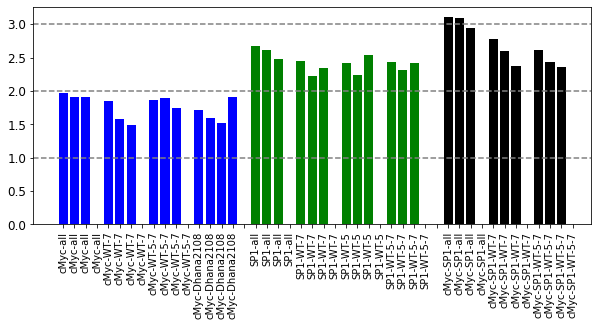

TF2: HSF1m [2.891      2.674      2.762             nan 2.67486549 2.56879324
 2.79938509        nan 3.00691776 2.78093774 2.79477325        nan
 2.95810056 2.70251397 2.68994413        nan 2.97135061 2.85675307
 2.63165075        nan 2.36693428 2.52155813 2.65953018 4.02022004] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False  True  True  True False  True  True  True False]


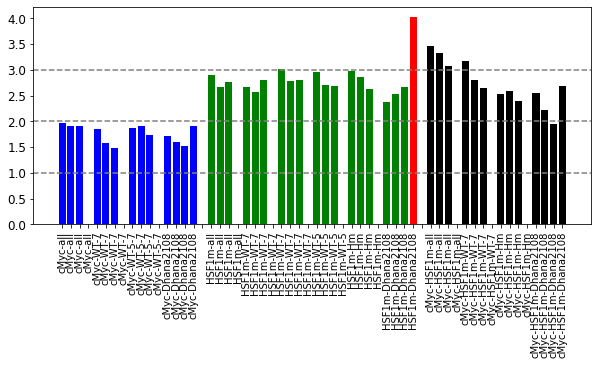

TF2: HSF1 [3.401      3.154      3.401             nan 3.96617986 3.7217525
 3.74942352        nan 3.82960894 3.87150838 3.98044693        nan
 4.32331438 4.12347685 4.06011373        nan 3.20463847 3.30695771
 3.42564802        nan] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False  True  True  True False]


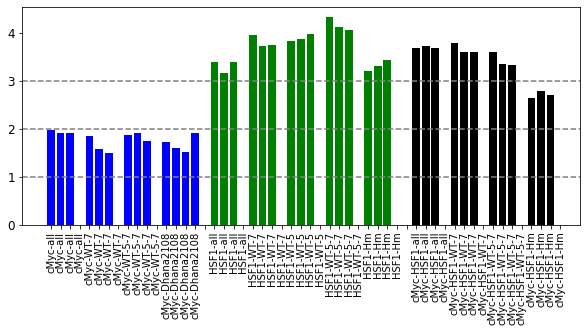

TF2: BRD4 [2.345      2.133      2.133             nan 1.73866257 1.76172175
 1.95080707        nan 2.03631285 1.87290503 1.86033519        nan
 2.19333875 1.94963444 1.98862713        nan 1.04668451 1.91019923
 1.88878977 2.17424918] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False False  True  True  True]


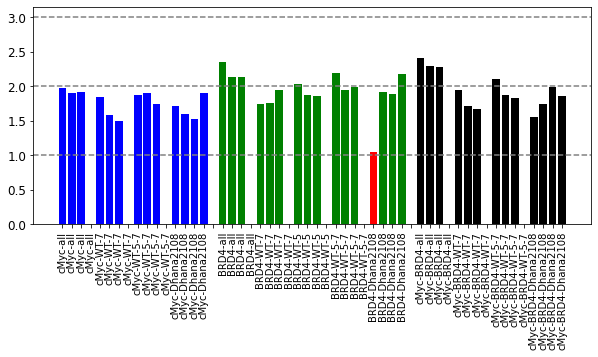

TF2: HSF1m [2.891      2.674      2.762             nan 2.67486549 2.56879324
 2.79938509        nan 3.00691776 2.78093774 2.79477325        nan
 2.95810056 2.70251397 2.68994413        nan 2.97135061 2.85675307
 2.63165075        nan 2.36693428 2.52155813 2.65953018 4.02022004] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False  True  True  True False  True  True  True False]


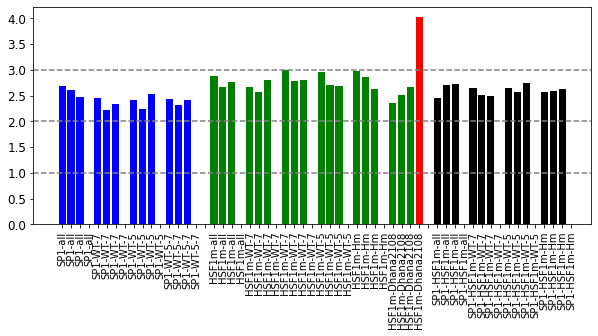

TF2: HSF1 [3.401      3.154      3.401             nan 3.96617986 3.7217525
 3.74942352        nan 3.82960894 3.87150838 3.98044693        nan
 4.32331438 4.12347685 4.06011373        nan 3.20463847 3.30695771
 3.42564802        nan] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False  True  True  True False]


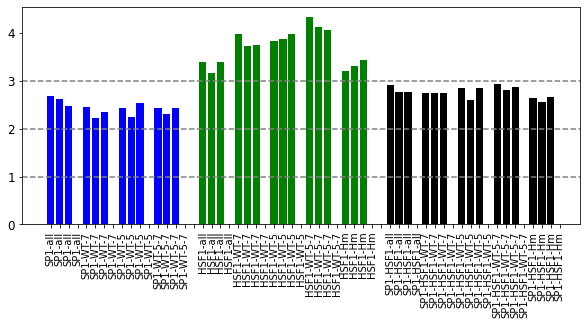

TF2: BRD4 [2.345      2.133      2.133             nan 1.73866257 1.76172175
 1.95080707        nan 2.03631285 1.87290503 1.86033519        nan
 2.19333875 1.94963444 1.98862713        nan 1.04668451 1.91019923
 1.88878977 2.17424918] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False False  True  True  True]


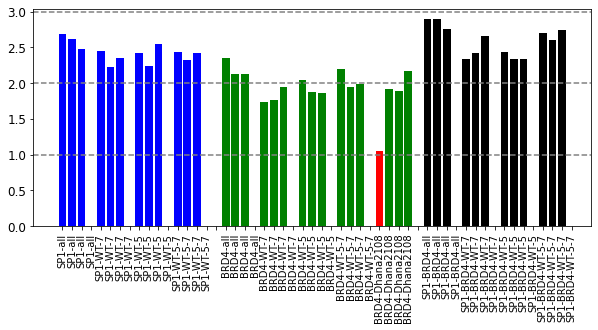

TF2: HSF1 [3.401      3.154      3.401             nan 3.96617986 3.7217525
 3.74942352        nan 3.82960894 3.87150838 3.98044693        nan
 4.32331438 4.12347685 4.06011373        nan 3.20463847 3.30695771
 3.42564802        nan] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False  True  True  True False]


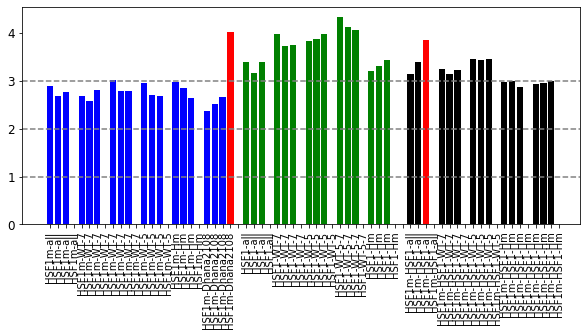

TF2: BRD4 [2.345      2.133      2.133             nan 1.73866257 1.76172175
 1.95080707        nan 2.03631285 1.87290503 1.86033519        nan
 2.19333875 1.94963444 1.98862713        nan 1.04668451 1.91019923
 1.88878977 2.17424918] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False False  True  True  True]


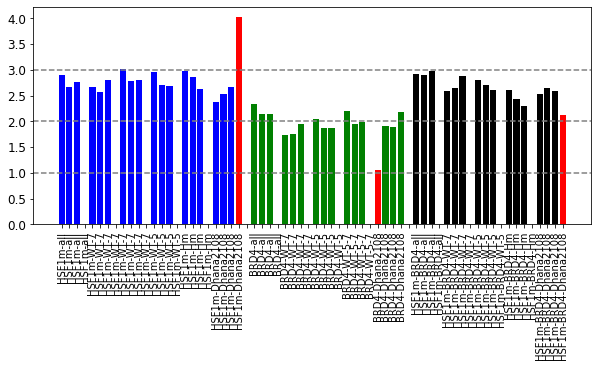

TF2: BRD4 [2.345      2.133      2.133             nan 1.73866257 1.76172175
 1.95080707        nan 2.03631285 1.87290503 1.86033519        nan
 2.19333875 1.94963444 1.98862713        nan 1.04668451 1.91019923
 1.88878977 2.17424918] [ True  True  True False  True  True  True False  True  True  True False
  True  True  True False False  True  True  True]


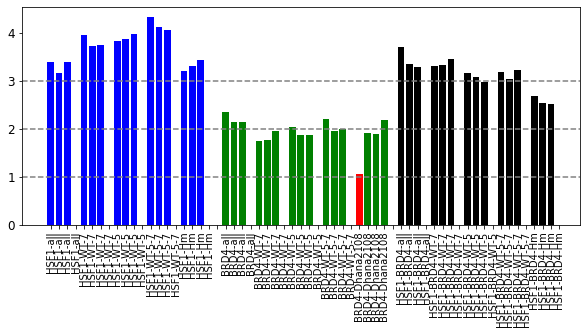

In [18]:
df=alldfsj
colorsl=["b","g","k"]
TFnames=('cMyc', 'SP1', 'HSF1m', 'HSF1', 'BRD4', 'empty')
for n1 in range(len(TFnames)-2):
    for n2 in range(n1+1,len(TFnames)-1):
        #TF1,TF2=TFcombi.split('-')
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        subdf=df[((df['activator1']==TF1)&(df['activator2']==TF2))|((df['activator1']==TF2)&(df['activator2']==TF1))] #[cGFP]
        
         
        ref1=df[(df['activator1']==TF1)&(df['activator2']==TF1)] 
        ref2=df[(df['activator1']==TF2)&(df['activator2']==TF2)]
        
        values=[]
        colors=[]

        fig,ax=plt.subplots(1,1,figsize=(10,4))
        values1=[]
        ticklabels=[]
        colors1=[]
        
        for i in range(len(ref1)):
            row=ref1.iloc[i]
            name=row["name"]
            foldchanges=row[["GFPfa1","GFPfa2","GFPfa3","GFPfa4"]].values
            values1.extend(list(foldchanges))
            ticklabels.extend([TF1+"-"+name]*4)
            colors1.extend([colorsl[0]]*4)
        values1=np.asarray(values1)
        #now detect outliers
        mask=mask_outliers(values1)
        
        #values1[~mask]=np.NaN
        colors1=np.asarray(colors1)
        colors1[~mask]="red"
        values.extend(list(values1))
        colors.extend(list(colors1))
        
        values.append(0)
        ticklabels.append("")
        colors.append("white")
        
        values2=[]
        colors2=[]
        
        for i in range(len(ref2)):
            row=ref2.iloc[i]
            name=row["name"]
            foldchanges=row[["GFPfa1","GFPfa2","GFPfa3","GFPfa4"]].values
            values2.extend(list(foldchanges))
            ticklabels.extend([TF2+"-"+name]*4)
            colors2.extend([colorsl[1]]*4)
        values2=np.asarray(values2)
        mask=mask_outliers(values2)
        print("TF2:", TF2, values2,mask)
        
        #values2[~mask]=np.NaN
        colors2=np.asarray(colors2)
        colors2[~mask]="red"
        colors.extend(list(colors2))
        values.extend(list(values2))
        
        values.append(0)
        ticklabels.append("")
        colors.append("white")
        
        values3=[]  
        colors3=[]
        for i in range(len(subdf)):
            row=subdf.iloc[i]
            name=row["name"]
            foldchanges=row[["GFPfa1","GFPfa2","GFPfa3","GFPfa4"]].values
            values3.extend(list(foldchanges))
            ticklabels.extend([TF1+"-"+TF2+"-"+name]*4)
            colors3.extend([colorsl[2]]*4)
        values3=np.asarray(values3)
        mask=mask_outliers(values3)
        #values3[~mask]=np.NaN
        colors3=np.asarray(colors3)
        colors3[~mask]="red"
        colors.extend(list(colors3))
        values.extend(list(values3))
        
        ax.bar(range(len(values)),values,color=colors)
        ax.set_xticks(range(len(values)))
        ax.set_xticklabels(ticklabels,rotation=90,fontsize=10)
        ax.axhline(y=1,linestyle="--",color="gray")
        ax.axhline(y=2,linestyle="--",color="gray")
        ax.axhline(y=3,linestyle="--",color="gray")
        plt.show()

In [19]:
#Now calculate a new df where the above-selected outliers are set to nan, so that we can then do all the analysis without those values
df_nooutliers=alldfsj.copy()
df=alldfsj
colnames_fc=np.array(["GFPfa1","GFPfa2","GFPfa3","GFPfa4"])
colnames_fc
for n1 in range(len(TFnames)-2):
    for n2 in range(n1+1,len(TFnames)-1):
        #TF1,TF2=TFcombi.split('-')
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        subdf=df[((df['activator1']==TF1)&(df['activator2']==TF2))|((df['activator1']==TF2)&(df['activator2']==TF1))] #[cGFP]
        
        
        ref1=df[(df['activator1']==TF1)&(df['activator2']==TF1)] 
        ref2=df[(df['activator1']==TF2)&(df['activator2']==TF2)]
        
        for s,selection in enumerate([subdf,ref1,ref2]):
            values=[]
            original_indexes=[]
            original_columns=[]
            original_names=[]
            for i in range(len(selection)):
                row=selection.iloc[i]
                values.extend(list(row[colnames_fc].values))
                original_index=selection.index[i]
                original_indexes.extend([original_index]*4)
                original_columns.extend(list(colnames_fc))
                original_names.extend([row["name"]]*4)
                
            mask=mask_outliers(values)
            for i in range(len(mask)):
                if not mask[i]:
                    
                    
                    if original_names[i]!="Dhana2108" and original_columns[i]!="GFPfa4": #these ones only have 3 repeats
                        if s==0:
                            print("Masking combi", TF1, TF2,end=",")
                        elif s==1:
                            print("Masking", TF1,end=",")
                        else:
                            print("Masking", TF2,end=",")
                        print(original_names[i],original_columns[i])
                        print(values)
                        print(original_columns)
                        print(original_names)
                        print(mask)
                        print(df.loc[original_indexes[i]])
                    elif original_names[i]=="Dhana2108":
                        if s==0:
                            print("Masking combi", TF1, TF2,end=",")
                        elif s==1:
                            print("Masking", TF1,end=",")
                        else:
                            print("Masking", TF2,end=",")
                        print(original_names[i],original_columns[i])
                        
                    df_nooutliers.loc[original_indexes[i],original_columns[i]]=np.NaN
                
        

Masking HSF1m,Dhana2108 GFPfa4
Masking BRD4,Dhana2108 GFPfa1
Masking HSF1m,Dhana2108 GFPfa4
Masking BRD4,Dhana2108 GFPfa1
Masking combi HSF1m HSF1,all GFPfa3
[3.133, 3.396, 3.844, nan, 3.237509608, 3.131437356, 3.214450423, nan, 3.452513966, 3.439944134, 3.45670391, nan, 2.963165075, 2.991814461, 2.877216917, nan, 2.93042292, 2.942701228, 2.991814461, nan]
['GFPfa1', 'GFPfa2', 'GFPfa3', 'GFPfa4', 'GFPfa1', 'GFPfa2', 'GFPfa3', 'GFPfa4', 'GFPfa1', 'GFPfa2', 'GFPfa3', 'GFPfa4', 'GFPfa1', 'GFPfa2', 'GFPfa3', 'GFPfa4', 'GFPfa1', 'GFPfa2', 'GFPfa3', 'GFPfa4']
['all', 'all', 'all', 'all', 'WT-7', 'WT-7', 'WT-7', 'WT-7', 'WT-5', 'WT-5', 'WT-5', 'WT-5', 'Hm', 'Hm', 'Hm', 'Hm', 'Hm', 'Hm', 'Hm', 'Hm']
[ True  True False False  True  True  True False  True  True  True False
  True  True  True False  True  True  True False]
activator1     HSF1m
affinity1     ZF(WT)
activator2      HSF1
affinity2     ZF(WT)
GFPfa1         3.133
GFPfa2         3.396
GFPfa3         3.844
name             all
GFPfa4  

In [20]:
#Compute a dataframe where each row is a pair, and each column has all the info for the synergy calculation

TFnames=('cMyc', 'SP1', 'HSF1m', 'HSF1', 'BRD4', 'empty')
affinities=['ZF(WT)']
cGFP=['GFPfa1','GFPfa2','GFPfa3','GFPfa4']


allrows=[]

for n1 in range(len(TFnames)):
    for n2 in range(n1,len(TFnames)):
        #TF1,TF2=TFcombi.split('-')
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        for af1 in affinities:
            for af2 in affinities:
                for df_name in df_nooutliers.groupby("name"):
                    name,df=df_name
                    combi1=df[(df['activator1']==TF1)&(df['activator2']==TF2)&(df['affinity1']==af1)&(df['affinity2']==af2)] #[cGFP]
                    combi2=df[(df['activator1']==TF2)&(df['activator2']==TF1)&(df['affinity1']==af2)&(df['affinity2']==af1)] #[cGFP]

                    found=True
                    if len(combi1)>0 and len(combi2)>0:
                        subdf=pd.concat([combi1,combi2])
                    elif len(combi1)>0:
                        subdf=combi1
                    elif len(combi2)>0:
                        subdf=combi2
                    else:
                        found=False
                        #if name=="Hm":
                        print("not found",name, TF1, af1, TF2, af2) #sanity check with what was measured in each file

                    if found:
                        #Notice that for "Hm", the measurements for the 1 TF at 2X concentration are missing for all TFs except HSF1 and HSF1m and so these are not considered
                        #reference values, with only TF1 or TF2 and a given affinity
                        ref1=df[(df['activator1']==TF1)&(df['activator2']==TF1)&(df['affinity1']==af1)&(df['affinity2']==af1)] 
                        ref2=df[(df['activator1']==TF2)&(df['activator2']==TF2)&(df['affinity1']==af2)&(df['affinity2']==af2)] 
                        if len(ref1)>0 and len(ref2)>0: #need to make sure both references exist
                            combival=np.nanmean(subdf[cGFP].values)
                            r1val=np.nanmean(ref1[cGFP].values)
                            r2val=np.nanmean(ref2[cGFP].values)

                            if r1val>r2val:
                                SAB=np.log2(combival/r1val)
                                SBA=np.log2(combival/r2val)
                                TFA=TF1
                            else:
                                SAB=np.log2(combival/r2val)
                                SBA=np.log2(combival/r1val)
                                TFA=TF2
                            if np.isnan(SAB) or np.isnan(SBA):
                                print("NAN!!",SAB,SBA,combival,r1val,r2val,np.log2(combival/r1val),np.log2(combival/r2val))

                            allrows.append([TF1,TF2,af1,af2,SAB,SBA,TFA,name,combival,r1val,r2val])
            

not found Hm cMyc ZF(WT) cMyc ZF(WT)
not found WT-5 cMyc ZF(WT) cMyc ZF(WT)
not found Dhana2108 cMyc ZF(WT) SP1 ZF(WT)
not found Hm cMyc ZF(WT) SP1 ZF(WT)
not found WT-5 cMyc ZF(WT) SP1 ZF(WT)
not found WT-5 cMyc ZF(WT) HSF1m ZF(WT)
not found WT-5-7 cMyc ZF(WT) HSF1m ZF(WT)
not found Dhana2108 cMyc ZF(WT) HSF1 ZF(WT)
not found WT-5 cMyc ZF(WT) HSF1 ZF(WT)
not found Hm cMyc ZF(WT) BRD4 ZF(WT)
not found WT-5 cMyc ZF(WT) BRD4 ZF(WT)
not found Dhana2108 cMyc ZF(WT) empty ZF(WT)
not found Hm cMyc ZF(WT) empty ZF(WT)
not found WT-5 cMyc ZF(WT) empty ZF(WT)
not found Dhana2108 SP1 ZF(WT) SP1 ZF(WT)
not found Hm SP1 ZF(WT) SP1 ZF(WT)
not found Dhana2108 SP1 ZF(WT) HSF1m ZF(WT)
not found WT-5-7 SP1 ZF(WT) HSF1m ZF(WT)
not found Dhana2108 SP1 ZF(WT) HSF1 ZF(WT)
not found Dhana2108 SP1 ZF(WT) BRD4 ZF(WT)
not found Hm SP1 ZF(WT) BRD4 ZF(WT)
not found Dhana2108 SP1 ZF(WT) empty ZF(WT)
not found Hm SP1 ZF(WT) empty ZF(WT)
not found WT-5-7 HSF1m ZF(WT) HSF1m ZF(WT)
not found Dhana2108 HSF1m ZF(WT) HS

In [21]:
dfsyn=pd.DataFrame(data=np.vstack(allrows),columns=['TF1','TF2','af1','af2','SAB','SBA','TFA','name',"fcGFPAB","fcGFP1","fcGFP2"])

In [22]:

print("conditions where TFA is not always the same:")
for df_ in dfsyn.groupby(["TF1","TF2","af1","af2"]):
    TFAs=df_[1]["TFA"].values
    TFAsu,indices,count=np.unique(TFAs,return_index=True,return_counts=True)
    if len(TFAsu)>1:
        #print(df_[1])
        display(df_[1])
        if True:
            argmax=np.argmax(count)
            mostcommon=TFAsu[argmax]
            print(count, argmax,mostcommon)
            #swap SAB and SBA:
            indices=df_[1].index
            for idx in indices:
                originalrow=dfsyn.iloc[idx]
                if originalrow["TFA"]!=mostcommon:
                    print("swapping")
                    SAB=originalrow["SAB"]
                    SBA=originalrow["SBA"]
                    dfsyn.loc[idx,"SAB"]=SBA
                    dfsyn.loc[idx,"SBA"]=SAB
                    dfsyn.loc[idx,"TFA"]=mostcommon+"(sw)"
                #print(dfsyn.iloc[idx])
            #print(indices)
    #print(df_[1])

conditions where TFA is not always the same:


This verifies that for all pairs of TFs, the TF with stronger expression is consistent across datasets.

In [23]:
#in case something was swapped in the code above, here doublecheck it is ok now
for df_ in dfsyn.groupby(["TF1","TF2","af1","af2"]):
    TFAs=df_[1]["TFA"].values
    TFAsu,indices,count=np.unique(TFAs,return_index=True,return_counts=True)
    if len(TFAsu)>1:
        #print(df_[1])
        display(df_[1])

In [24]:
#this can be saved if desired
#dfsyn.to_csv("./files/2021_10_15_dfsyn_noout.df")

In [25]:
import matplotlib
def compute_percentiles(values):
    vals=values.flatten()
    vals=vals[~np.isnan(vals)] #make sure there are not nans
    np.random.seed(1)
    niters=1000
    out=np.zeros(niters)
    N=len(vals)
    for i in range(niters):
        choice=np.random.choice(vals,size=N,replace=True)
        out[i]=np.mean(choice)
    #plt.hist(out)
    #plt.show()
    #print(min(out),(max(out)))
    return np.percentile(out,[2.5,97.5])

colorsnew={"SP1":"#bc5b2d","HSF1m":"#e69c0c","cMyc":"#030c7b","BRD4":"#0569f5","HSF1":"#82dabd","empty":"darkgrey"}
colorsnew2={"SP1":"#7a3818","HSF1m":"#b37807","cMyc":"k","BRD4":"#020d9c","HSF1":"#69b59c","empty":"grey"}
markerdict={"WT-WT":"o",
            "WT-5X":"^",
            "5X-WT":"v",
            "WT-7X":">",
            "7X-WT":"<",
            "5X-7X":"*",
            "7X-5X":"X",
            "5X-5X":"D",
            "7X-7X":"s"}
markerdictkorder=["WT-WT","5X-5X","7X-7X","WT-5X","5X-WT","WT-7X","7X-WT","5X-7X","7X-5X"]
colorsdict={'c-S':'yellowgreen', 'c-m':'green', 'c-H':'purple', 'c-B':'blue', 
             'S-m':'orange', 'S-H':'magenta',
            'S-B':'darkolivegreen',  'm-H':'plum', 'm-B':'palegreen', 
            'H-B':'pink', 
            'c-c':'b','c-e':'b', 'S-e':'r','S-S':'r', 'm-m':'orange','m-e':'orange', 'H-H':'purple', 'H-e':'purple', 'B-B':'lightblue','B-e':'lightblue', 'e-e':'grey'}
markers={"SP1":"s","HSF1m":"s","cMyc":"H","BRD4":"H","HSF1":"^"}
#sizes={"SP1":100,"HSF1m":100,"cMyc":100,"BRD4":15,"HSF1":30}
colorsorder=['c-S','m-B','c-m','S-B','m-H','H-B','S-H','c-H','c-B','S-m']
afpat=re.compile(r'\((.+)\)')
green="#c6cdad"
blue="#d3dbe4"
red="#e3cbc8"

12
empty - [1.371      1.324      1.345      1.16218294 1.16218294 1.33743274
 1.48743017 1.31145251 1.26536313 1.44760357 1.35012185 1.33549959] 1.3249391204166667 1.162182936 1.487430167
32
empty empty [1.17       1.278      1.247      1.15295926 1.16679477 1.34665642
 1.42458101 1.28212291 1.21927374 1.46709992 1.35987002 1.32087734
 1.41778174 1.24174844 1.34879572 1.28932501 1.17       1.278
 1.247      1.15295926 1.16679477 1.34665642 1.42458101 1.28212291
 1.21927374 1.46709992 1.35987002 1.32087734 1.41778174 1.24174844
 1.34879572 1.28932501] 1.295805393183021 1.152959262 1.467099919
9
cMyc - [1.505      1.479      1.505      1.38816295 1.40199846 1.47117602
 1.57432981 1.39398863 1.4378554 ] 1.4618345862222222 1.388162952 1.574329813
26
cMyc cMyc [1.968      1.907      1.912      1.84473482 1.58647194 1.48962337
 1.86677498 1.90089358 1.74004874 1.71989295 1.59381505 1.52245019
 1.90544157 1.968      1.907      1.912      1.84473482 1.58647194
 1.48962337 1.86677498 1.9008935

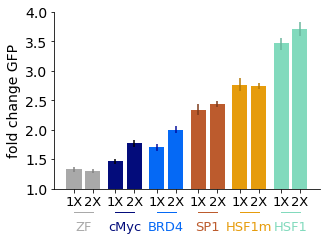

In [26]:
#barplot of response to each TF alone
#Fig3 main
mpl.rcParams["font.size"]=14
fontsize=13
df=df_nooutliers

fig=plt.figure(figsize=(4.75,3.25))
ax=fig.add_subplot(111)
af1="ZF(WT)"
TFind=["empty", "cMyc", "BRD4", "SP1", "HSF1m", "HSF1"]
colorsb=["gray","dodgerblue","dodgerblue","orange","orange","purple"]
xlocs=[]
for t,TF in enumerate(TFind):
    TF1=TF
    for t2,TF2 in enumerate(['-',TF1]):
        found=True
        if TF2==TF1:
            af2="ZF(WT)"
        else:
            af2='-'
    
        combi1=df[(df['activator1']==TF1)&(df['activator2']==TF2)&(df['affinity1']==af1)&(df['affinity2']==af2)] #[cGFP]
        combi2=df[(df['activator1']==TF2)&(df['activator2']==TF1)&(df['affinity1']==af2)&(df['affinity2']==af1)] #[cGFP]
        
        if len(combi1)>0 and len(combi2)>0:
            subdf=pd.concat([combi1,combi2])
        elif len(combi1)>0:
            subdf=combi1
        elif len(combi2)>0:
            subdf=combi2
        else:
            found=False
        if not found:
            print("not found")
        else:
            v1=subdf[cGFP].values
            v1=v1[~np.isnan(v1)]
            
            mv1=np.nanmean(v1)
            print(len(v1))
            print(TF1,TF2,v1,mv1,np.min(v1),np.max(v1))
            
            #yerr=[mv1-np.min(v1),np.max(v1)-mv1]
            percentiles=compute_percentiles(v1)
            #print("percentiles", percentiles, mv1)
            #yerr=[mv1-]
            lower=mv1-percentiles[0]
            upper=percentiles[1]-mv1
            #print("mean",mv1)
            #print("lower",lower)
            #print("upper",upper)
            ax.bar(2.2*t+t2,mv1,yerr=np.array([[lower],[upper]]),color=colorsnew[TF],ecolor=colorsnew2[TF],width=0.8)
            xlocs.append(2.2*t+t2)
            #error is the range of the data
            

ax.set_xticks(xlocs)
ax.set_xticklabels(["1X","2X"]*6,fontsize=fontsize)
for i in range(len(TFind)):
    TF=TFind[i]
    if TF=="empty":
        TFtext="ZF"
    else:
        TFtext=TF
    ax.text(2.2*i+0.5,0.3,TFtext,fontsize=fontsize,horizontalalignment='center',color=colorsnew[TF])
# new clear axis overlay with 0-1 limits
for i in range(len(TFind)):
    x,y = np.array([[2.2*i, 2.2*i+1], [0.6,0.6]])
    line = matplotlib.lines.Line2D(x, y, lw=1., color=colorsnew[TFind[i]])
    
    ax.add_line(line)
    line.set_clip_on(False)

    #ax.plot([0.95*2*i,1.05*2*i],[-0.6,-0.6])
    #ax.draw(2*i,-0.6,)
ax.set_ylim(1,4)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.set_ylabel("fold change GFP")
#plt.savefig("../figs/singleTF.pdf")
plt.show()
          

In [27]:
dfsyn["SAB"]=pd.to_numeric(dfsyn["SAB"])
dfsyn["SBA"]=pd.to_numeric(dfsyn["SBA"])
dfsyn["fcGFP1"]=pd.to_numeric(dfsyn["fcGFP1"])
dfsyn["fcGFP2"]=pd.to_numeric(dfsyn["fcGFP2"])
dfsyn["fcGFPAB"]=pd.to_numeric(dfsyn["fcGFPAB"])


In [28]:
fontsize=14


cMyc SP1 3
[0.04439412 0.14249287 0.23346239]
[0.42584902 0.65490106 0.65874701]
c-S
cMyc HSF1m 3
[-0.09830207  0.05072267  0.24422971]
[0.47974319 0.80716175 0.76921089]
c-m
cMyc HSF1 3
[-0.2836463  -0.05998485  0.15679156]
[0.89955209 1.1567951  0.93954215]
c-H
cMyc BRD4 4
[-0.15545452 -0.08017035 -0.02959478  0.07897846]
[0.08500525 0.0746388  0.11807508 0.27103133]
c-B
SP1 HSF1m 3
[-0.0697018  -0.12142566 -0.07594417]
[0.14367036 0.12260524 0.02375239]
S-m
SP1 HSF1 4
[-0.4922736  -0.53985299 -0.47118673 -0.241746  ]
[0.20538742 0.26189051 0.23318503 0.11571997]
S-H
SP1 BRD4 4
[-0.01773309  0.16468835  0.08109233  0.13681139]
[0.3023079  0.3913341  0.44583065 0.37004313]
S-B
HSF1m HSF1 4
[-0.1674019  -0.17471952 -0.25514447 -0.02374169]
[0.06482813 0.30956933 0.20519639 0.23402772]
m-H
HSF1m BRD4 4
[ 0.03990926 -0.03962891 -0.03606419  0.07987063]
[0.37749475 0.49378424 0.57270503 0.41279894]
m-B
HSF1 BRD4 4
[-0.34238296 -0.40420837 -0.17875064  0.05571382]
[0.67531904 0.62418088 0.

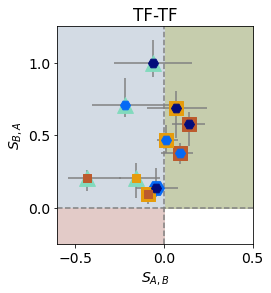

In [38]:
# Synergy plot for WT data
#Fi3 main

af1="ZF(WT)"
af2="ZF(WT)"
fig,ax=plt.subplots(1,1,figsize=(3.5,4))
subdf=dfsyn[(dfsyn["af1"]==af1)&(dfsyn["af2"]==af2)]

for n1 in range(len(TFnames)-2):
    for n2 in range(n1+1,len(TFnames)-1): #last one is empty, so not used for this plot
        #TF1,TF2=TFcombi.split('-')
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        data=subdf[(subdf["TF1"]==TF1)&(subdf["TF2"]==TF2)]
        print(TF1,TF2,len(data))
        SABlist=data["SAB"].values
        SBAlist=data["SBA"].values
        print(SABlist)
        print(SBAlist)
        mSAB=np.nanmean(SABlist)
        mSBA=np.nanmean(SBAlist)
        #error is the range of the data
        xerr=np.array([[mSAB-np.nanmin(SABlist)],[np.nanmax(SABlist)-mSAB]])
        yerr=np.array([[mSBA-np.nanmin(SBAlist)],[np.nanmax(SBAlist)-mSBA]])
        if TF1!="HSF1m":
            i1=TF1[0]
        else:
            i1="m"
        if TF2!="HSF1m":
            i2=TF2[0]
        else:
            i2="m"
        key="-".join([i1,i2])
        print(key)
        ax.errorbar(mSAB,mSBA,xerr=xerr,yerr=yerr,color="gray",marker='o',ms=1,zorder=2) #,linestyle=':')
        m1=markers[TF1]
        m2=markers[TF2]
        if m1=="s" and m2=="s":
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=50,color=colorsnew[TF1],zorder=4)
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=200,color=colorsnew[TF2],zorder=3)
        elif m1=="s" and m2=="H":
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=200,color=colorsnew[TF1],zorder=3)
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=100,color=colorsnew[TF2],zorder=4)
        elif m1=="H" and m2=="s":
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=100,color=colorsnew[TF1],zorder=4)
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=200,color=colorsnew[TF2],zorder=3)
        elif m1=="s" and m2=="^":
            
            ax.scatter(mSAB,mSBA,marker=markers[TF1],s=50,color=colorsnew[TF1],zorder=4)
            ax.scatter(mSAB,mSBA,marker=markers[TF2],s=250,color=colorsnew[TF2],zorder=3)
        else:
            if TF1=="HSF1" and TF2=="BRD4":
                ax.scatter(mSAB,mSBA,marker=markers[TF1],s=250,color=colorsnew[TF1],zorder=3)
                ax.scatter(mSAB,mSBA,marker=markers[TF2],s=100,color=colorsnew[TF2],zorder=4)
                
            else:
                ax.scatter(mSAB,mSBA,marker=markers[TF2],s=250,color=colorsnew[TF2],zorder=3)
                ax.scatter(mSAB,mSBA,marker=markers[TF1],s=100,color=colorsnew[TF1],zorder=4)
            
#for key in colorsorder:
#    color=colorsdict[key]
#    ax.scatter(-10,-10,marker='o',color=color,label=key,s=50)
#ax.legend(loc='upper left',bbox_to_anchor=(1.025,1.05),ncol=1)
#ax.legend(loc='upper ')
ax.set_xticks(np.arange(-1,2.5,0.5))
ax.set_yticks(np.arange(-1,2.5,0.5))
ax.set_xlim(-0.6,0.5)
ax.set_ylim(-0.25,1.25)
ax.fill_between([0,1],2,color=green,zorder=1)
ax.fill_between([-1,0],2,color=blue,zorder=1)
ax.fill_between([-1,0],-1,color=red,zorder=1)


ax.set_xlabel(r'$S_{A,B}$',fontsize=fontsize)
ax.set_ylabel(r'$S_{B,A}$',fontsize=fontsize)
ax.tick_params(axis='both',labelsize=fontsize)

#ax.legend(loc=lc,bbox_to_anchor=bbox,ncol=2)
ax.axhline(y=0,linestyle='--',color='grey')
ax.axvline(x=0,linestyle='--',color='grey')
ax.set_title("TF-TF")
#plt.savefig('./files/WT.pdf',bbox_inches='tight')
plt.show()

v1 [1.68539994 1.64027671 1.929     ]
v2 [2.51600753 2.77094543 2.77566667]
e1 cMyc [1.64027671 1.929     ]
e2 HSF1m [2.51600753 2.77566667]
e12 [2.35028249 3.28766667]
error [[0.11128217 0.17153234 0.48573387]
 [0.17744112 0.08812679 0.45165031]]
v1 [2.40083799 2.33973866 2.59033333]
v2 [2.78351955 2.77094543 2.77566667]
e1 SP1 [2.33973866 2.59033333]
e2 HSF1m [2.77094543 2.78351955]
e12 [2.54727133 2.65223464]
error [[0.103898   0.00576512 0.0636751 ]
 [0.14669667 0.006809   0.0412882 ]]
v1 [2.81991814 2.78351955 2.77094543 2.77566667]
v2 [3.31241473 3.89385475 3.81245196 3.31866667]
e1 HSF1m [2.77330605 2.80885528]
e2 HSF1 [3.3155407  3.85315335]
e12 [3.01075833 3.38590695]
error [[0.0142064  0.26880633 0.20379391]
 [0.02134283 0.26880633 0.17135471]]
v1 [1.99107939 1.92318436 1.8170638  2.20366667]
v2 [2.51600753 2.78351955 2.77094543 2.77566667]
e1 BRD4 [1.8605677  2.13354609]
e2 HSF1m [2.57974201 2.78037602]
e12 [2.61556871 2.87588413]
error [[0.12318086 0.13179279 0.11715208]
 [

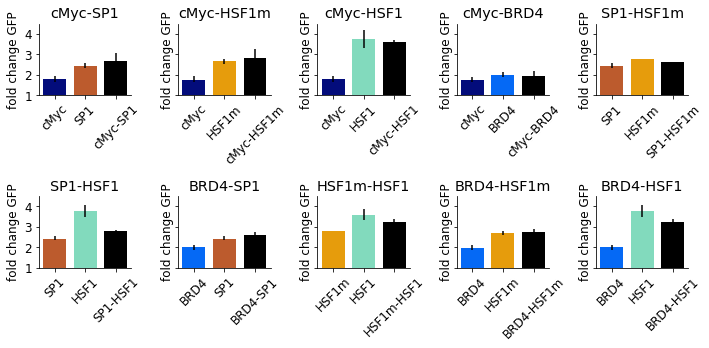

In [40]:
# Now plot barplots for individual TF pairs
#Fig S3
mpl.rcParams["font.size"]=12

af1="ZF(WT)"
af2="ZF(WT)"

subdf=dfsyn[(dfsyn["af1"]==af1)&(dfsyn["af2"]==af2)]

fig,axes=plt.subplots(2,5,figsize=(10,5),sharey=True)
nplot=0
for n1 in range(len(TFnames)-2):
    for n2 in range(n1+1,len(TFnames)-1):
        #TF1,TF2=TFcombi.split('-')
        TF1=TFnames[n1]
        TF2=TFnames[n2]
        data=subdf[(subdf["TF1"]==TF1)&(subdf["TF2"]==TF2)]
        v1=data["fcGFP1"].values
        v2=data["fcGFP2"].values
        v12=data["fcGFPAB"].values
        #print(TF1,TF2,v1,v2)
        #SABlist=data["SAB"].values
        #SBAlist=data["SBA"].values
        
        mv1=np.nanmean(v1)
        mv2=np.nanmean(v2)
        mv12=np.nanmean(v12)
        #print(v12,mv12)
        
        if TF1!="HSF1m":
            i1=TF1[0]
        else:
            i1="m"
        if TF2!="HSF1m":
            i2=TF2[0]
        else:
            i2="m"
        key="-".join([i1,i2])
        
        if mv2<mv1:
            mv1_=mv1
            v1_=v1
            TF1_=TF1
            
            mv1=mv2
            mv2=mv1_
            v1=v2
            v2=v1_
            TF1=TF2
            TF2=TF1_
            
        #error is the range of the data
        #yerr=np.array([[mv1-min(v1),max(v1)-mv1],[mv2-min(v2),max(v2)-mv2],[mv12-min(v12),max(v12)-mv12]]).reshape(2,3)
        
            
        v1=v1[~np.isnan(v1)]
        v2=v2[~np.isnan(v2)]
        v12=v12[~np.isnan(v12)]
        yerr1=compute_percentiles(v1)
        yerr2=compute_percentiles(v2)
        yerr12=compute_percentiles(v12)
        yerr=np.array([[mv1-yerr1[0],mv2-yerr2[0],mv12-yerr12[0]],[yerr1[1]-mv1,yerr2[1]-mv2,yerr12[1]-mv12]])

        
        if TF1=="HSF1m" or TF2=="HSF1m":
            print("v1",v1)
            print("v2",v2)
            print("e1",TF1,yerr1)
            print("e2",TF2,yerr2)
            print("e12",yerr12)
            
            print("error",yerr)
        
        #fig,ax=plt.subplots(1,1,figsize=(3,3))
        ax=axes[nplot//5,nplot%5]
        ax.set_title(TF1+"-"+TF2)
        colors_=[colorsnew[TF1],colorsnew[TF2],"k"]
        patches=ax.bar(range(3),[mv1,mv2,mv12],yerr=yerr,color=colors_,width=0.75) #,color=colorsdict[key],marker='o') #,linestyle=':')
        #for p in range(2):
            #patch=patches[p]
            #patch.set_alpha(0.5)
        ax.set_xticks(range(3))
        ax.set_xticklabels([TF1,TF2,TF1+"-"+TF2],rotation=45)
        ax.set_ylim(1,4.5)
        ax.set_yticks([1,2,3,4])
        ax.set_ylabel("fold change GFP")
        nplot+=1
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
plt.tight_layout()
#plt.savefig("../figs/WTdetail.pdf",bbox_inches="tight")
plt.show()


cMyc empty 3
SP1 empty 4
HSF1m empty 3
HSF1 empty 4
BRD4 empty 4


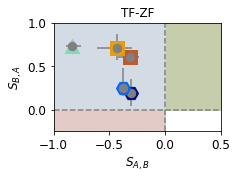

In [41]:
# WT-empty
#Fig S3

fontsize=12
af1="ZF(WT)"
af2="ZF(WT)"
fig,ax=plt.subplots(1,1,figsize=(3,2))
subdf=dfsyn[(dfsyn["af1"]==af1)&(dfsyn["af2"]==af2)]

for n1 in range(len(TFnames)-1):
    n2=len(TFnames)-1
    #TF1,TF2=TFcombi.split('-')
    TF1=TFnames[n1]
    TF2=TFnames[n2]
    data=subdf[(subdf["TF1"]==TF1)&(subdf["TF2"]==TF2)]
    print(TF1,TF2,len(data))
    SABlist=data["SAB"].values
    SBAlist=data["SBA"].values
    mSAB=np.mean(SABlist)
    mSBA=np.mean(SBAlist)
    #error is the range of the data
    xerr=np.array([[mSAB-min(SABlist)],[max(SABlist)-mSAB]])
    yerr=np.array([[mSBA-min(SBAlist)],[max(SBAlist)-mSBA]])
    if TF1!="HSF1m":
        i1=TF1[0]
    else:
        i1="m"
    if TF2!="HSF1m":
        i2=TF2[0]
    else:
        i2="m"
    key="-".join([i1,i2])
    ax.errorbar(mSAB,mSBA,xerr=xerr,yerr=yerr,color="gray",marker='o',ms=1,zorder=2) #,linestyle=':')
    m1=markers[TF1]
    m2="o"
    
    ax.scatter(mSAB,mSBA,marker=m1,s=200,color=colorsnew[TF1],zorder=3)
    ax.scatter(mSAB,mSBA,marker=m2,s=70,color="gray",zorder=3)
#for key in colorsorder:
#    color=colorsdict[key]
#    ax.scatter(-10,-10,marker='o',color=color,label=key,s=50)
#ax.legend(loc='upper left',bbox_to_anchor=(1.025,1.05),ncol=1)
#ax.legend(loc='upper ')
ax.set_xticks(np.arange(-1,2.5,0.5))
ax.set_yticks(np.arange(-1,2.5,0.5))
ax.set_xlim(-1,0.5)

ax.set_ylim(-0.25,1)


ax.set_xlabel(r'$S_{A,B}$',fontsize=fontsize)
ax.set_ylabel(r'$S_{B,A}$',fontsize=fontsize)
ax.tick_params(axis='both',labelsize=fontsize)

#ax.legend(loc=lc,bbox_to_anchor=bbox,ncol=2)
ax.axhline(y=0,linestyle='--',color='grey')
ax.axvline(x=0,linestyle='--',color='grey')
ax.set_title("TF-ZF",fontsize=fontsize)
ax.fill_between([0,1],2,color=green,zorder=1)
ax.fill_between([-1,0],2,color=blue,zorder=1)
ax.fill_between([-1,0],-1,color=red,zorder=1)
#plt.savefig('../figs/WT_empty.pdf',bbox_inches='tight')
plt.show()